# **ADApocalypse present :** "Her Side Story" - Beyond the Bechdel Test: Studying How Women Are Put Aside in Cinema 

## Project Initialisation

### Import libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
tqdm.pandas()
import json
from collections import defaultdict
from transformers import pipeline
import ast
import plotly.express as px
import plotly.graph_objects as go

# not displaying warnings
pd.options.mode.chained_assignment = None 

# to facilitate the use of py files
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Constants

In [7]:
DATA_FOLDER_PATH = 'src/data/raw_data/'
CLUSTER_JSON_PATH =  'src/data/clusters.json'

### Filtering and transformation of several columns

# 1. Loading files


## A. CMU Movie dataset

Loading the files from the CMU movie dataset.

In [8]:
from src.data.data_loader import load_movies_metadata, load_char_metadata, load_plot_summaries, load_tvtropes_data, load_name_clusters


In [9]:
movies_metadata_df = load_movies_metadata(DATA_FOLDER_PATH)
char_metadata_df = load_char_metadata(DATA_FOLDER_PATH)
plot_summaries_df = load_plot_summaries(DATA_FOLDER_PATH)
tvtropes_df = load_tvtropes_data(DATA_FOLDER_PATH)
name_clusters_df = load_name_clusters(DATA_FOLDER_PATH)

# 2. Filtering the movies

We decided to filter our raw data in order to keep the movie intersection of the 3 following files: movie.metadata, character.metadata and imdb.ratings.

We applied the following rules to filter and preprocess the files: 
- all movies without release date were dropped
- all movies with a release date outside of the range 1910-2013 were dropped
- the release date were standardized into realase year
- thanks to another external dataset the missing gender were added
- the characters without a gender were dropped 

## Faire csv avec movies_metadata_df, char_metadata_df (eviter de run pdt 4min a chaque fois lol)

In [10]:
from src.utils.methods import get_intersection

movies_metadata_df, char_metadata_df, intersection_ids = get_intersection(movies_metadata_df, char_metadata_df)


Now, our dataframes are preprocessed and contain the same movies.

In [11]:
print(f'We now have {intersection_ids.shape[0]} movies.')

We now have 59776 movies.


We noticed that the columns languages and genres of the movie.metadata.csv were very broad and included a large number of different propositions, such as more than 20 different Indian dialects. In order to perform a complete analysis without getting lost in interpretation we decided to cluster them. Moreover, some countries have been wrongly labeled or are ancient territories, which we clusted for equivalent reasons.

## 2.1 Loading External datasets

Loading IMDB dataset. We plan to use it in the future to evaluate the success of a movie and link it with the genders of the actors.

The title.basics.tsv and title.ratings.tsv files are too big to be stored in the repository so all results are pre run but cannot be find again.

## Faire csv avec imdb ratings (juste read le csv)

In [12]:
from src.utils.methods import process_imdb_ratings

imdb_ratings_df = process_imdb_ratings(movies_metadata_df)

FileNotFoundError: [Errno 2] No such file or directory: 'src/data/external_data/raw_data/title.basics.tsv'

In [ ]:
imdb_ratings_df.head()

,wikipedia_movie_id,imdb_movie_id,movie_name,movie_release_date,averageRating,numVotes
0,975900,tt0228333,Ghosts of Mars,2001,4.9,58732.0
1,28463795,tt0094806,Brun bitter,1988,5.6,42.0
2,9363483,tt0094320,White Of The Eye,1987,6.1,3071.0
3,261236,tt0083949,A Woman in Flames,1983,5.9,648.0
4,10408933,tt0029852,Alexander's Ragtime Band,1938,6.8,2353.0


In [ ]:
imdb_ratings_df.shape

(44868, 6)

In the future, we will load the Bechdel Dataset and use it to conduct gender analysis.

# 1. MOVIES

## 1.1 METADATA

### In order to perform a complete analysis, we intend to further add the columns 'director_name', 'director_gender' and 'budget' to the movies_metadata dataframe, thanks to the wikipedia_movie_id allowing us to access the library wikipedia_api

In [ ]:
movies_metadata_df.shape

(59776, 9)

In [ ]:
movies_metadata_df.isnull().sum()

wikipedia_movie_id              0
freebase_movie_id               0
movie_name                      0
movie_release_date              0
movie_box_office_revenue    51619
movie_runtime               10451
movie_languages                 0
movie_countries                 0
movie_genres                    0
dtype: int64

In [ ]:
print(f"There are {movies_metadata_df['wikipedia_movie_id'].nunique()} unique wikipedia_movie_id")
print(f"and there are {movies_metadata_df['freebase_movie_id'].nunique()} unique freebase_movie_id")
print(f"but there are {movies_metadata_df['movie_name'].nunique()} unique movie_name")
print(f"and there are {movies_metadata_df.shape[0]} rows in the dataset")


There are 59776 unique wikipedia_movie_id
and there are 59776 unique freebase_movie_id
but there are 55392 unique movie_name
and there are 59776 rows in the dataset


In [19]:
def extract_names_from_tuples(languages):
    lang_dict = ast.literal_eval(languages)
    return list(lang_dict.values())

We want to change the format of the column languages, countries and genres from tuple to list, because the freebase ids are not relevant.

In [20]:
movies_metadata_df['movie_languages'] = movies_metadata_df['movie_languages'].apply(extract_names_from_tuples)
movies_metadata_df['movie_countries'] = movies_metadata_df['movie_countries'].apply(extract_names_from_tuples)
movies_metadata_df['movie_genres'] = movies_metadata_df['movie_genres'].apply(extract_names_from_tuples)

We have seen that there are a lot of different languages, countries and genres (mettre les chiffres), sometimes they were repetive and not consistent. We decided to create manually different clusters in clusters.json file. We import the clusters.

In [21]:
with open(CLUSTER_JSON_PATH, 'r') as file:
    data = json.load(file)

In [22]:
languages_cluster = data['Languages']
countries_cluster = data['Countries']
genres_cluster = data['Genres']


In [23]:
def map_cluster(mapping, elem):
    for generic, variants in mapping.items():
        if elem in variants:
            return generic
    return elem

In [24]:
movies_metadata_df['movie_languages'] = movies_metadata_df['movie_languages'].apply(lambda x: list(dict.fromkeys([map_cluster(languages_cluster, elem) for elem in x]).keys()))
movies_metadata_df['movie_countries'] = movies_metadata_df['movie_countries'].apply(lambda x: list(dict.fromkeys([map_cluster(countries_cluster, elem) for elem in x]).keys()))
movies_metadata_df['movie_genres'] = movies_metadata_df['movie_genres'].apply(lambda x: list(dict.fromkeys([map_cluster(genres_cluster, elem) for elem in x]).keys()))


### 1.1.1 GENRES

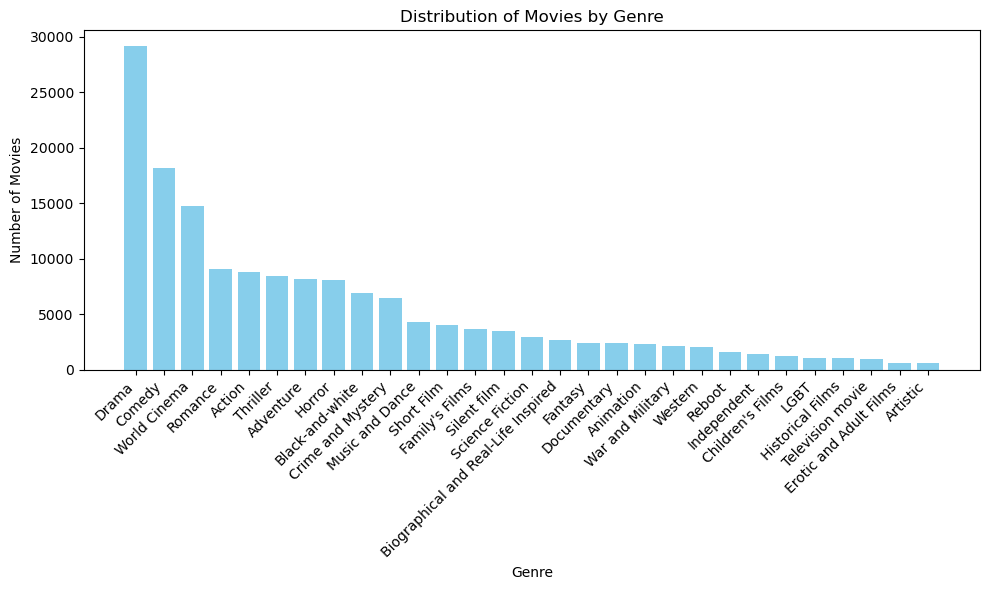

In [25]:
all_genres = movies_metadata_df['movie_genres'].copy()
all_genres = [genre for sublist in movies_metadata_df['movie_genres'] for genre in sublist]
genre_counts = Counter(all_genres)
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])

genre_df = genre_df.sort_values(by='Count', ascending=False)
# keep only the genres with more than 500 movies
genre_df = genre_df[genre_df['Count'] > 500]

# Plot the distribution of genres
plt.figure(figsize=(10, 6))
plt.bar(genre_df['Genre'], genre_df['Count'], color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies by Genre')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The first analysis of the movie genres give us ideas and insights on how to conduct our future analysis.

From this distribution of movies by genre, we could select the top-10 genres and look at the gender distribution on them. 

Additionnally, we will also focus on some other genres because of clichés that we have spotted while doing the genre clustering:
- feminist films
- pornographic films
- LGBT films
- war and military films


### 1.1.2. LANGUAGES

We investigated this feature about the movie dataset and we have seen that it is quite similar to the country feature. Hence, we decide for further analysis to focus on the country feature since it can give us information about how a country's culture can influence the gender representation in movies.

### 1.1.3. COUNTRIES

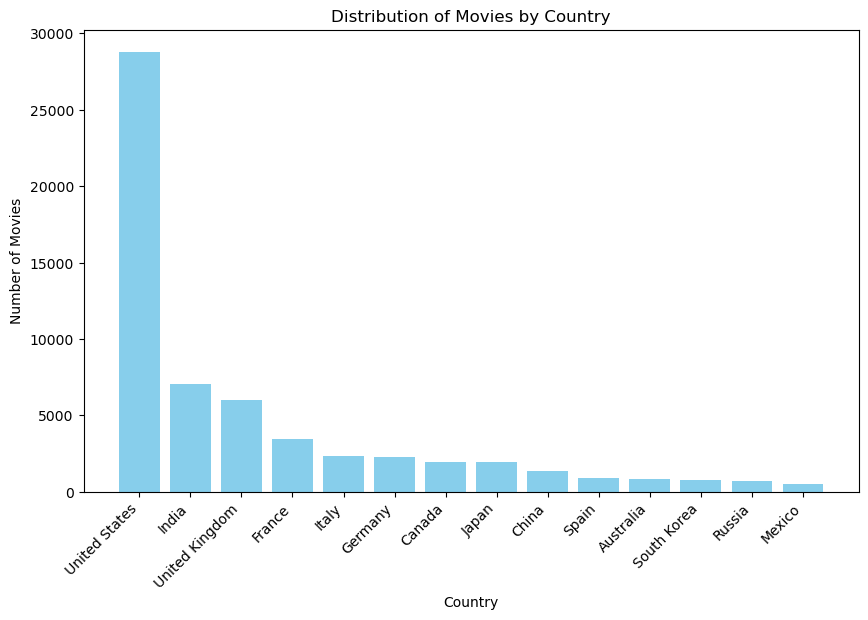

In [26]:
all_countries = movies_metadata_df['movie_countries'].copy()
all_countries = [genre for sublist in movies_metadata_df['movie_countries'] for genre in sublist]
countries_counts = Counter(all_countries)

country_df = pd.DataFrame(countries_counts.items(), columns=['Country', 'Count'])
country_df = country_df.sort_values(by='Count', ascending=False)
country_df = country_df[country_df['Count'] > 500]

plt.figure(figsize=(10, 6))
plt.bar(country_df['Country'], country_df['Count'], color='skyblue')
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies by Country')
plt.xticks(rotation=45, ha='right') 
plt.show()

We can see that we have a lot of movies from USA, UK, and Europe. Our analysis would be occidental-centered with an exception for India and north Asia countries.

It could be really interesting to look at the difference of the gender representation depending on the part of the world. 

### 1.1.4. Box office revenue

There is a lot of missing values (more than 50%), we would like to add an external dataset. We could link it to a movie success in order to look for any correlation with the gender distribution of actors.

### 1.1.5. Runtime

In [27]:
movies_metadata_df['movie_runtime'].info()

<class 'pandas.core.series.Series'>
Index: 59776 entries, 0 to 81740
Series name: movie_runtime
Non-Null Count  Dtype  
--------------  -----  
49325 non-null  float64
dtypes: float64(1)
memory usage: 934.0 KB


There is some missing runtime values. We are still thinking about whether to use the runtime or not and hence if we should find values to remplace them.

Here are some statistics about the runtime. We can see that the minimum and maximum runtime are extreme, we could look into that more carefully in order to know why. It could also be interesting to explore if there is any correlation with the gender of the actors or characters.

In [28]:
movies_metadata_df['movie_runtime'].describe()

count    4.932500e+04
mean     1.196767e+02
std      4.859412e+03
min      1.500000e-01
25%      8.500000e+01
50%      9.500000e+01
75%      1.090000e+02
max      1.079281e+06
Name: movie_runtime, dtype: float64

### 1.1.6. Release date

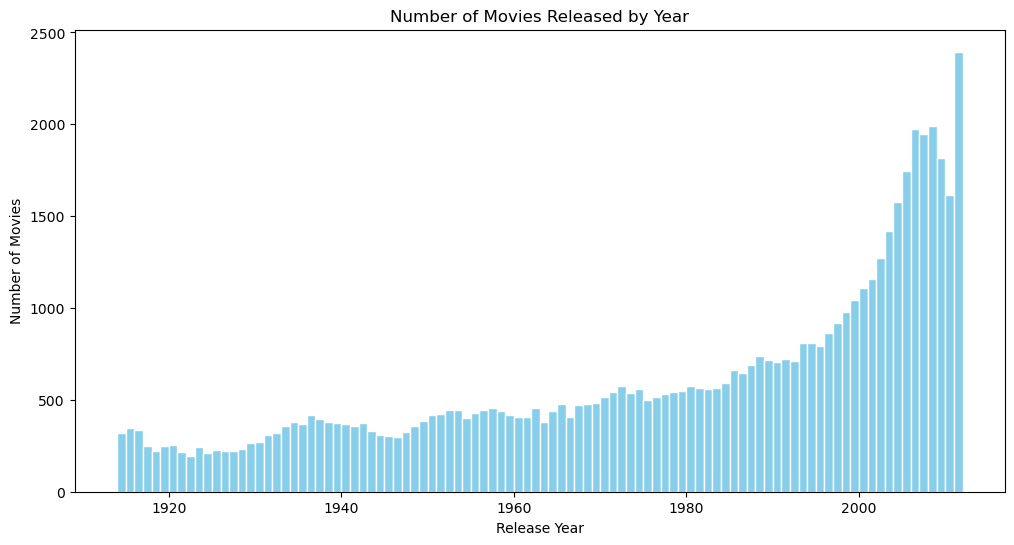

In [29]:
movies_metadata_df['movie_release_date'] = movies_metadata_df['movie_release_date'].apply(lambda x: int(x))

plt.figure(figsize=(12, 6))
plt.hist(movies_metadata_df['movie_release_date'], bins=range(movies_metadata_df['movie_release_date'].min(), movies_metadata_df['movie_release_date'].max() + 1), color='skyblue', edgecolor='white')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies Released by Year')
plt.show()

We can observe that the distribution of movies produced between 1910 until 2013 follows a heavy left-skewed distribution, with a notable increase during World War I. We can now wonder whether the temporal evolution of the number of movies follows the same distribution depending on the gender of the director.

# 2. CHARACTERS

## 2.1. METADATA

We use the preprocessed dataframe.

### 2.1.1. Distributions of characters per movie

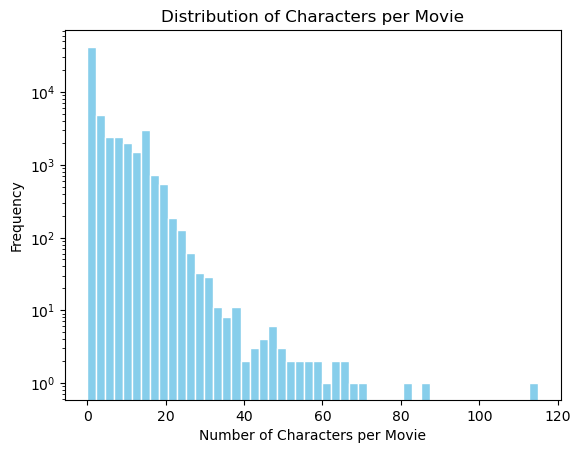

In [ ]:
char_per_movie = char_metadata_df.groupby("wikipedia_movie_id")['char_name'].count().reset_index()
max_characters = char_per_movie['char_name'].max()
max_movie_id = char_per_movie[char_per_movie['char_name'] == max_characters]['wikipedia_movie_id'].values[0]

plt.hist(char_per_movie['char_name'], bins=50, log=True, color = "skyblue", edgecolor="white") 
plt.xlabel('Number of Characters per Movie')
plt.ylabel('Frequency')
plt.title('Distribution of Characters per Movie')
plt.show()

This plot shows us that the majority of movies register less than 20 characters, although the distribution is pretty constant until ~45 characters. We also notice a few outliers with more than 80 and 115 characters per movie. It would be interesting to link those results alongside with the runtime of the movie and the gender of the director.

### 2.1.2. Distribution of female and male characters

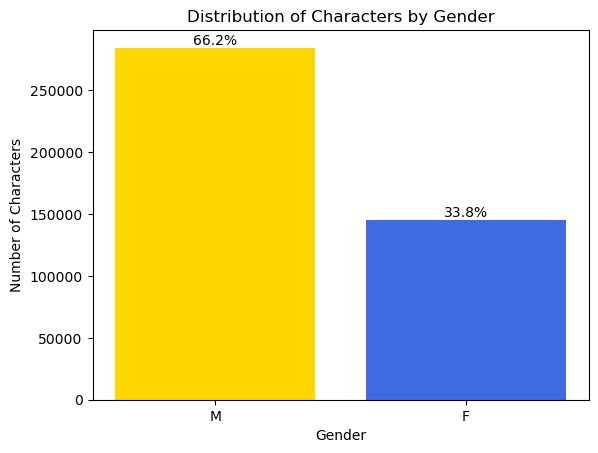

In [ ]:
characters_gender = char_metadata_df[char_metadata_df["actor_gender"].isin(["F", "M"])]
gender_counts = characters_gender["actor_gender"].value_counts()

total_characters = gender_counts.sum()
percentages = (gender_counts / total_characters) * 100

plt.bar(gender_counts.index, gender_counts.values, color=['gold', 'royalblue'])
plt.xlabel('Gender')
plt.ylabel('Number of Characters')
plt.title('Distribution of Characters by Gender')

for index, (count, percentage) in enumerate(zip(gender_counts.values, percentages)):
    plt.text(index, count, f'{percentage:.1f}%', ha='center', va='bottom')


This graph illustrates genre inequalities amongst movie characters. As we can see, overall only 1/3 of the characters are female. A further analysis would be to compare the distribution of movie characters between genders based on the genre, gender of the movie director and release date of the movie.

Let's groupby on release_years_df to get also the number of movies

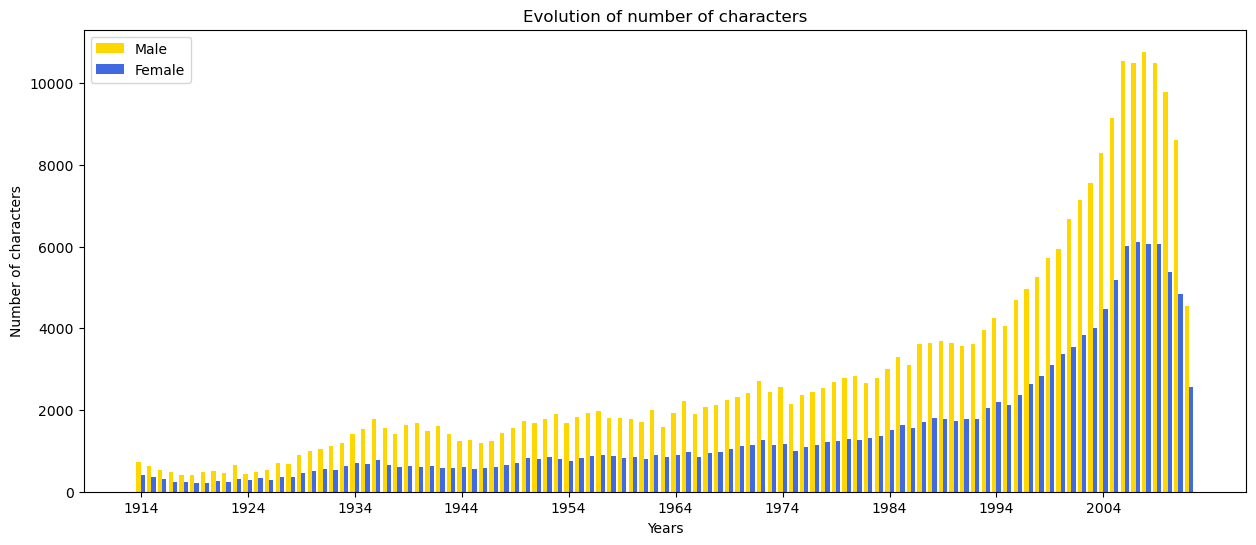

In [ ]:
# convert genders into numbers
char_metadata_df["actor_gender_binary"] = char_metadata_df["actor_gender"].apply(lambda x: 0 if x=="M" else 1)
characters_gender_time = char_metadata_df.groupby("movie_release_date")["actor_gender_binary"].value_counts().unstack(fill_value=0).reset_index()

release_years_df = char_metadata_df.groupby("movie_release_date")["wikipedia_movie_id"].count()
characters_gender_time["Num_movies"] = release_years_df.values

fig, ax = plt.subplots(figsize=(15,6))
width = 0.4
x = characters_gender_time.index  # Years
x_male = x - width / 2
x_female = x + width / 2

# Plot bars side by side
ax.bar(x_male, characters_gender_time[0], width, label="Male", color="gold")
ax.bar(x_female, characters_gender_time[1], width, label="Female", color="royalblue")
ax.set_title("Evolution of number of characters")
ax.legend()
ax.set_ylabel("Number of characters")
ax.set_xlabel("Years")
ax.set_xticks(x[::10])  # Adjust to show ticks every 30 years
ax.set_xticklabels(characters_gender_time["movie_release_date"][::10]);

Overall, there are consequently more male than female characters, almost double amount. They both follow the same left-skewed distribution, which is due to the augmenting number of movies over the period studied.

### 2.1.3. Proportion of female characters

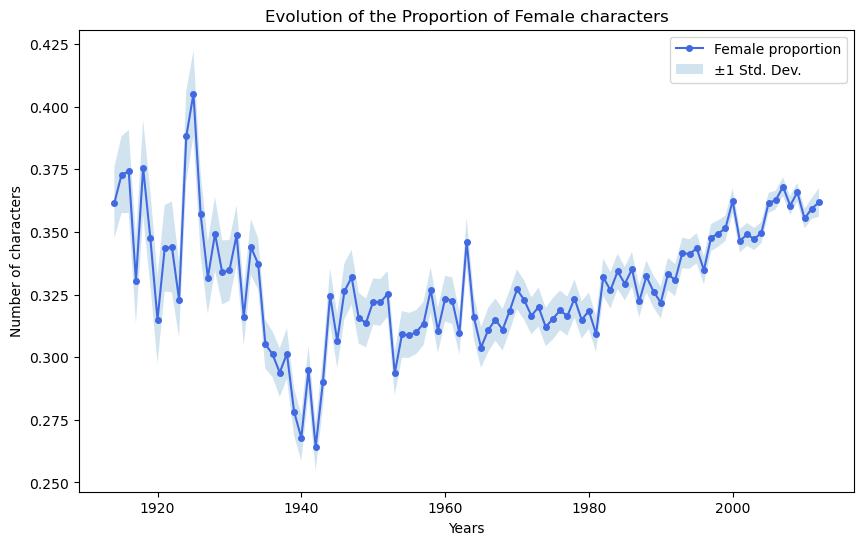

In [ ]:
characters_gender_time["proportion_F"] = characters_gender_time[1]/ (characters_gender_time[1]+characters_gender_time[0])
characters_gender_time["std_F"] = np.sqrt((characters_gender_time["proportion_F"]*(1-characters_gender_time["proportion_F"])) / (characters_gender_time[1]+characters_gender_time[0]))
characters_gender_time_filtered = characters_gender_time[characters_gender_time["Num_movies"] >= 200]

y_err = characters_gender_time_filtered["std_F"]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(characters_gender_time_filtered["movie_release_date"], characters_gender_time_filtered["proportion_F"], "-o", label="Female proportion", color="royalblue", markersize=4)
ax.fill_between(characters_gender_time_filtered["movie_release_date"], characters_gender_time_filtered["proportion_F"] - y_err, characters_gender_time_filtered["proportion_F"] + y_err, alpha=0.2, label='±1 Std. Dev.')
ax.set_title("Evolution of the Proportion of Female characters")
ax.set_xlabel("Years")
ax.set_ylabel("Number of characters")
ax.legend()

Interestingly, the number of female characters over the years reached its maximum (around 40%) in 1925, which correspond to the introduction of sound in movies. The proportion then drastically dropped until 1942, with over a fourth of the characters represented by women. It then increased and stabilized at around 30-35%, where it steadily increased reaching  36% in 2013.

### 2.1.4. Distribution of the actor's ages

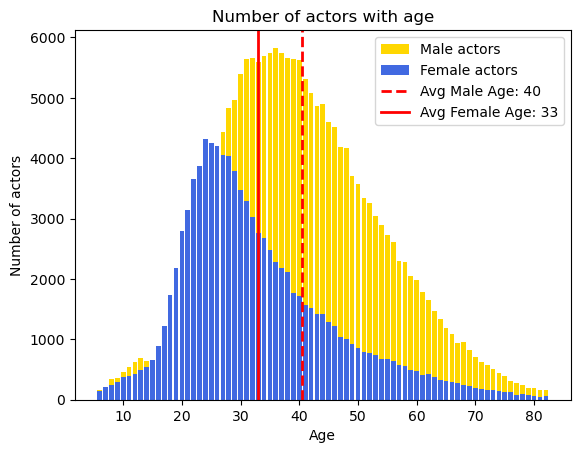

In [ ]:
actors_age = char_metadata_df.copy(deep=True)
actors_age_gender = actors_age.groupby("actor_age")["actor_gender_binary"].value_counts().unstack(fill_value=0).reset_index()
actors_age_gender["Tot_actors"] = actors_age_gender[0] + actors_age_gender[1]
actors_age_gender = actors_age_gender[actors_age_gender["Tot_actors"] >= 200]

# Calculate weighted average age for each gender
avg_age_male = (actors_age_gender['actor_age'] * actors_age_gender[0]).sum() / actors_age_gender[0].sum()
avg_age_female = (actors_age_gender['actor_age'] * actors_age_gender[1]).sum() / actors_age_gender[1].sum()

fig, ax = plt.subplots()

ax.bar(actors_age_gender['actor_age'], actors_age_gender[0], label="Male actors", color="gold")
ax.bar(actors_age_gender['actor_age'], actors_age_gender[1], label="Female actors", color="royalblue")

ax.axvline(avg_age_male, color="red", linestyle="--", linewidth=2, label=f"Avg Male Age: {avg_age_male:.0f}")
ax.axvline(avg_age_female, color="red", linestyle="-", linewidth=2, label=f"Avg Female Age: {avg_age_female:.0f}")

#get handles and labels
handles, labels = ax.get_legend_handles_labels()

# #specify order of items in legend
order = [2, 3, 0, 1]

#add legend to plot
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax.set_title("Number of actors with age")
ax.set_xlabel("Age")
ax.set_ylabel("Number of actors");

This graph illustrates the inequalities regarding opportunities given to older actors. Whereas the majority of male actors are between 30 and 50 years old, with an average of 40 years old, most women actors are only between 20 and 30 years old, with an average of 33 years old. The male actors seem to have a longer career than female ones. Once again, it would be interesting to compare this number according to the gender of the movie director and the genre of the movie. 

## 2.2. CHARACTER TYPES

In [ ]:
# we keep unique values
character_types = tvtropes_df['character_type'].unique()

In [ ]:
tvtropes_df.head()

,character_type,metadata
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."


Here, we separate the columns so it is more easy to understand.

In [ ]:
tvtropes_df['metadata'] = tvtropes_df['metadata'].apply(ast.literal_eval)
tvtropes_df = pd.concat([tvtropes_df.drop(['metadata'], axis=1), tvtropes_df['metadata'].apply(pd.Series)], axis=1)
tvtropes_df = tvtropes_df.rename(columns={'char': 'char_name', 'actor': 'actor_name', 'movie': 'movie_name', 'id': 'char_actor_id'})
tvtropes_df.head()

,character_type,char_name,movie_name,char_actor_id,actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


We add the character information and especially its gender.

In [ ]:
tvtropes_df['actor_gender'] = tvtropes_df['actor_name'].map(char_metadata_df.set_index('actor_name')['actor_gender'].to_dict())


We count the number of female and male characters. There is much more males, which introduces some bias in our analysis. We are not sure if we want to use this file since it could contain biased information about genders, and the file is only 500 rows so it is quite small.

In [ ]:
tvtropes_gender = tvtropes_df.groupby('actor_gender').size().reset_index(name='counts')
tvtropes_gender

,actor_gender,counts
0,F,69
1,M,432


We plot the repartition of the gender characters along the tv tropes.

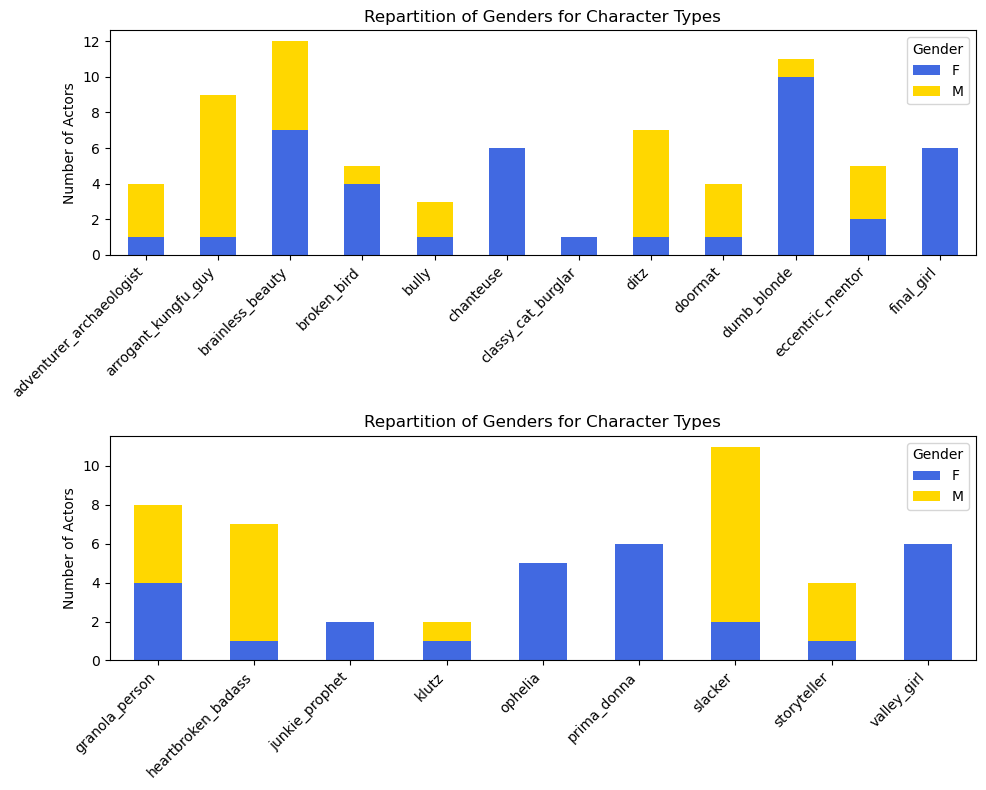

In [ ]:
# Filter rows where 'actor_gender' contains 'F'
character_type_gender_counts = tvtropes_df.groupby(['character_type', 'actor_gender']).size().unstack(fill_value=0)
filtered_character_type_gender_counts = character_type_gender_counts[character_type_gender_counts['F'] > 0]

# Set up the number of subplots
categories_per_subplot = 12
num_subplots = (len(filtered_character_type_gender_counts) + categories_per_subplot - 1) // categories_per_subplot

fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 4 * num_subplots))

# Plot each subset in a separate subplot
for i in range(num_subplots):
    start = i * categories_per_subplot
    end = start + categories_per_subplot
    subset = filtered_character_type_gender_counts.iloc[start:end]

    subset.plot(kind='bar', stacked=True, ax=axes[i], color=['royalblue', 'gold'])
    axes[i].set_title(f"Repartition of Genders for Character Types")
    axes[i].set_xlabel("")  # Character type
    axes[i].set_ylabel("Number of Actors")
    axes[i].legend(title="Gender")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')


plt.tight_layout()
plt.show()


Here, we only plotted the categories that have some female characters. As expected following societal cliches, female characters are often juged based on their appearance (ex :"dumb blond") whereas more flatterous characters are predominantly males such as "byronic_hero" or "master_swodsman". Some categories are 100% female characters: chanteuse, final_girl, ophelia, prima_donna, valley_girl. Indeed, some genders word are contained in the title of the tv tropes. As for the category brainless beauty, we observe it is almost 50-50 but considering there is really less female characters, it is obvious to see that it is disproportionate.

## 2.3. CHARACTER NAMES 

For now, we will not analyze the character names.

In [ ]:
name_clusters_df

,Cluster_name,Char_actor_id
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn
...,...,...
2661,John Rolfe,/m/0k5_ql
2662,John Rolfe,/m/02vd6vs
2663,Elizabeth Swann,/m/0k1xvz
2664,Elizabeth Swann,/m/0k1x_d


## 3. PLOT SUMMARIES

We focused our analysis on the content of plot summaries by using sentiment analysis on each plot, linking it to the dominent emotion.

In [ ]:
# Keep only the movies that are common to our movies dataset
df_plot_summaries_filtered = plot_summaries_df[plot_summaries_df['wikipedia_movie_id'].isin(movies_metadata_df['wikipedia_movie_id'])]
df_plot_summaries_filtered.reset_index(drop=True, inplace=True)

Investigating the length of the plots, we see that the majority of the plots are between 50 and 250 words long. 

In [ ]:
# charge pipeline for emotion detection
emotion_pipeline = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Then, we perform a sentiment analysis using Hugging Face transformers pipeline.

In [ ]:
# Function for analyzing the emotion of a text

def emotion_analysis(text):
    chunks = [text[i:i+512] for i in range(0, len(text), 512)]
    results = [emotion_pipeline(chunk) for chunk in chunks]

    # Initialize a dictionary to accumulate scores for each emotion
    emotion_scores = defaultdict(list)

    #Process each chunk and accumulate scores
    for chunk_result in results:
        for emotion in chunk_result:
            for i in range(len(emotion)):
                emotion_scores[emotion[i]['label']].append(emotion[i]['score'])
            #print(emotion_scores[emotion['label']])
            #emotion_scores[emotion['label']].append(emotion['score'])

    # Calculate the average score for each emotion
    average_scores = {emotion: sum(scores) / len(scores) for emotion, scores in emotion_scores.items()}

    return average_scores

In [ ]:
# get the emotions and dominant emotion for the first n plots
def n_first_emotions(n, df):
    df = plot_summaries_df.head(n)
    df['emotion_scores'] = df['plot_summary'].progress_apply(emotion_analysis)
    df['dominant_emotion'] = df['emotion_scores'].apply(lambda x: max(x, key=x.get))
    return df

100%|██████████| 2000/2000 [06:49<00:00,  4.89it/s]


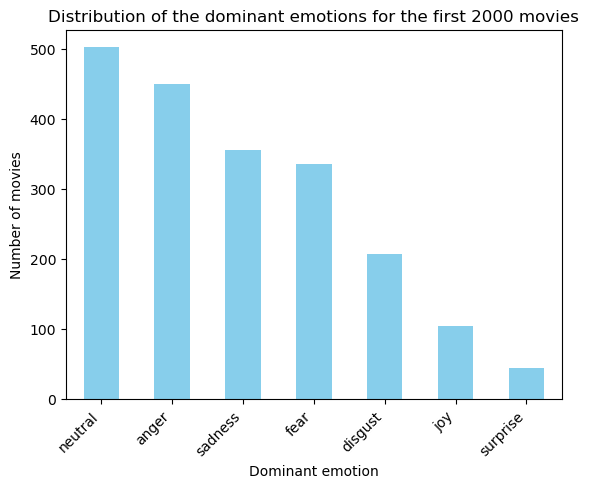

In [ ]:
# Analyzing emotions of the first 2000 plot summaries
df_plot_emotions_2000 = n_first_emotions(2000, plot_summaries_df)
df_plot_emotions_2000['dominant_emotion'].value_counts().plot(kind='bar', color='skyblue')

plt.title('Distribution of the dominant emotions for the first 2000 movies')
plt.xlabel('Dominant emotion')
plt.ylabel('Number of movies')
plt.xticks(rotation=45, ha='right')
plt.show()


We see that more film summaries are categorised as including anger, whereas few contain joy or surprise. For further analysis, we want to investigate the potential relationship between the emotions and the genders of the main actors.

# 4. Movie Directors

# faire avec movie metadata df déjà présent & processed

In [30]:
from src.data.data_loader import load_movies_director, load_movies_metadata

In [31]:
movies_director = load_movies_director("src/data/external_data/")
movies_director.head()
movies_director.rename(columns={'gender': 'director_gender'}, inplace=True)

In [32]:
movies_director['wikipedia_movie_id'] = movies_director['wikipedia_movie_id'].astype(int)

In [ ]:
#movies_metadata = load_movies_metadata('src/data/raw_data/') 

In [33]:
 # Create new dataframe combining data of movies_metadata and movies_director
movies_directors_combined = movies_metadata_df.join(movies_director.set_index('wikipedia_movie_id'), on='wikipedia_movie_id')
movies_directors_combined = movies_directors_combined[movies_directors_combined['director_gender'].notna()]

movies_directors_combined.to_csv('src/data/external_data/movies_directors_combined.csv', index=False)

In [34]:
movies_directors_combined.head()

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,director_name,director_gender
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English],[United States],"[Thriller, Science Fiction, Horror, Adventure,...",John Carpenter,M
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],[Thriller],Donald Cammell,M
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama],Robert van Ackeren,M
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,[English],[United States],"[Music and Dance, Comedy, Black-and-white]",Henry King,M
10,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,[English],[United States],"[Drama, Black-and-white]",Dorothy Arzner,F


In [35]:
# distribution of genders amongst movie directors
fig = px.histogram(movies_director, x='director_gender', title='Gender distribution of movies director')
fig.show()